# Script 02: Integration of reference ctrl object

## Steps involved

### i. pre-processing & PCA
### ii. harmonisation of PCs

In [1]:
import os
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as ad
from scipy.stats import median_abs_deviation

In [2]:
# HELPER FUNCTION: build adata from basic blocks
def build_sample_adata(
    sample_dir,
    sample_id,
    matrix_name="matrix.mtx",
    barcodes_name="barcodes.tsv",
    features_name="features.tsv",
    cell_metadata_name="metadata.csv",
    obs_label_for_sample="mouse_id"
):

    # build file paths
    matrix_path = os.path.join(sample_dir, matrix_name)
    barcodes_path = os.path.join(sample_dir, barcodes_name)
    features_path = os.path.join(sample_dir, features_name)
    cell_metadata_path = os.path.join(sample_dir, cell_metadata_name)

    # read cts matrix and transpose
    adata = sc.read_mtx(matrix_path).T

    # barcodes & features
    barcodes = pd.read_csv(barcodes_path, header=None, sep="\t")[0]
    features = pd.read_csv(features_path, header=None, sep="\t")[0]

    # assign to the adata object
    adata.obs_names = barcodes
    adata.var_names = features

    # store sampleID as a column
    adata.obs[obs_label_for_sample] = sample_id

    # check for cell metadata
    if not os.path.exists(cell_metadata_path):
        raise FileNotFoundError(f"No cell metadata: {cell_metadata_path}")

    # read in cell meta
    cell_meta = pd.read_csv(cell_metadata_path,
                            index_col=0,
                            )

    # test indices overlap
    assert all(idx in adata.obs.index for idx in cell_meta.index)

    # merge cell meta based on indices
    adata.obs = adata.obs.join(cell_meta, how='left')

    return adata


I. read in data

In [3]:
# cellranger counts
data_dir = os.path.join("data", "cellranger")

In [4]:
# sample-level metadata dataframe
sample_meta = pd.read_csv("data/mice_and_batches.csv")

In [5]:
# ctrl samples to subset by
ctrl_samples = sample_meta[sample_meta["genotype"] == "ctrl"]

In [6]:
# loop over all the ctrl samples
adatas = []
for idx, row in ctrl_samples.iterrows():
    sample_id = str(row["mouse_id"])
    sample_dir = os.path.join(data_dir, sample_id, "outs", "soupx")

    adata = build_sample_adata(
        sample_dir=sample_dir,
        sample_id=sample_id,
        matrix_name="matrix.mtx",
        barcodes_name="barcodes.tsv",
        features_name="features.tsv",
        cell_metadata_name="metadata.csv",
        obs_label_for_sample="mouse_id"
    )
    adatas.append(adata)

In [7]:
# merge with anndata.concat()
adata = ad.concat(adatas, axis=0)

adata

AnnData object with n_obs × n_vars = 11107 × 33696
    obs: 'mouse_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'old_label', 'percent.mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'counts_outlier', 'features_outlier', 'mito_outlier', 'RNA_snn_res.0.8', 'seurat_clusters', 'scDblFinder.class', 'scDblFinder.score', 'S.Score', 'G2M.Score', 'Phase'

In [8]:
# make sampleIDs catcategorical
adata.obs["mouse_id"] = adata.obs["mouse_id"].astype("category")

In [9]:
# add batch info
sample_meta["mouse_id"] = sample_meta["mouse_id"].astype(str).astype("category")
sample_to_batch = sample_meta.set_index("mouse_id")["batch"]
adata.obs["batch"] = adata.obs["mouse_id"].map(sample_to_batch)

In [10]:
del(adatas)

II. inspect unintegrated data

i. pre-process

In [11]:
# normalize counts
sc.pp.normalize_total(adata, 
                      target_sum=1e4, 
                      inplace=True)

In [12]:
# log+1 transform
sc.pp.log1p(adata)

In [13]:
# block HVGs by batch and by mouse_id
for key, label in [('batch', 'highly_variable_batch'), ('mouse_id', 'highly_variable_mouse')]:
    sc.pp.highly_variable_genes(adata, 
                                batch_key=key, 
                                n_top_genes=3000, 
                                inplace=True)
    adata.var[label] = adata.var['highly_variable']

In [14]:
# intersect both groupy pf hvgs
intersected_hvgs = adata.var[adata.var['highly_variable_batch'] & 
                             adata.var['highly_variable_mouse']
                             ].index
len(intersected_hvgs)

2368

In [15]:
# load cell cycle genes
s_genes = pd.read_csv("metadata/cell_cycle/mart_export_s.txt", header=None)[2].tolist()
g2m_genes = pd.read_csv("metadata/cell_cycle/mart_export_g2m.txt", header=None)[2].tolist()
cell_cycle_genes = set(s_genes + g2m_genes)

In [16]:
# remove them from HVG selection
hvgs_filtered = set(intersected_hvgs) - cell_cycle_genes
len(hvgs_filtered)

2368

NB: looks like there were no overlaps :D

In [17]:
# save HVGs
pd.DataFrame({'highly_variable_genes': list(hvgs_filtered)}).to_csv(
    "n3000_blocked_by_ID_BATCH_CCFiltered.csv", index=False
)

In [18]:
# and set these HVGs
adata.var['highly_variable'] = adata.var.index.isin(hvgs_filtered)

ii. basic unintegrated analysis

In [19]:
import igraph

In [20]:
sc.pp.pca(adata,
          n_comps=30,
          use_highly_variable=True)

/home/koellere/miniconda3/envs/scanpy_sce/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [21]:
sc.pp.neighbors(adata)

/home/koellere/miniconda3/envs/scanpy_sce/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
sc.tl.leiden(adata,
             key_added = "leiden_unintegrated")

/tmp/ipykernel_37740/3087533994.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,


In [23]:
sc.tl.umap(adata)

In [24]:
adata.obsm['X_umap_unintegrated'] = adata.obsm['X_umap'] 

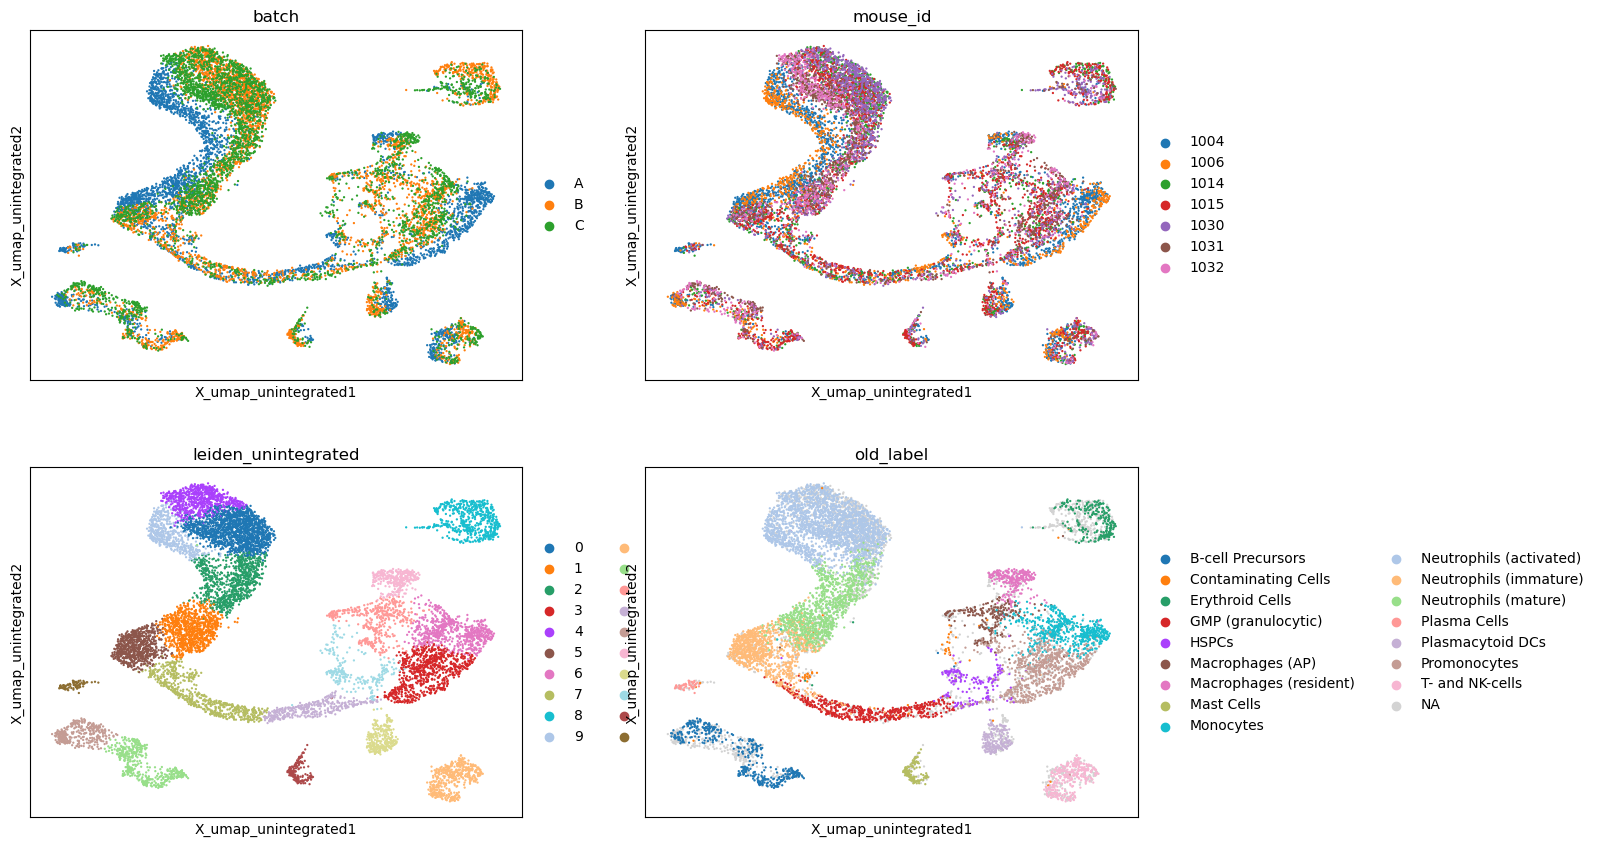

In [25]:
sc.pl.embedding(adata,
                basis = "X_umap_unintegrated",
                color = ["batch", "mouse_id", "leiden_unintegrated", "old_label"],
                ncols=2,
                save="overview.png")

III. harmonypy harmonisation of PCs

In [26]:
import harmonypy as hm

In [27]:
unintegrated_pca_saved = adata.obsm['X_pca']

In [28]:
# # attempt 1 (only batch, theta 0)
# matrix = unintegrated_pca_saved
# batch_vars = ['batch']
# theta_values = [1]
# nclust = 50
# max_iter = 100

In [29]:
# harmony params
matrix = unintegrated_pca_saved
batch_vars = ['batch'] # adding "mouse_id" leads to overcorrection. The samplesa are already reasonably aligned
theta_values = [1]
nclust = 50
max_iter = 100

In [30]:
# run harmonypy
ho = hm.run_harmony(
    data_mat=matrix,
    meta_data=adata.obs,
    vars_use=batch_vars,
    theta=theta_values,
    nclust=nclust,
    max_iter_kmeans=max_iter,
    #max_iter_harmony=10,
    verbose=True
)

2025-02-15 19:17:05,586 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-02-15 19:17:07,016 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-15 19:17:07,055 - harmonypy - INFO - Iteration 1 of 10
2025-02-15 19:17:12,316 - harmonypy - INFO - Iteration 2 of 10
2025-02-15 19:17:13,094 - harmonypy - INFO - Iteration 3 of 10
2025-02-15 19:17:13,475 - harmonypy - INFO - Iteration 4 of 10
2025-02-15 19:17:13,860 - harmonypy - INFO - Iteration 5 of 10
2025-02-15 19:17:14,246 - harmonypy - INFO - Converged after 5 iterations


IV. inspect harmony integration results

In [31]:
adata.obsm['X_pca'] = ho.Z_corr.T

In [44]:
# run basic analysis
sc.pp.neighbors(adata)
sc.tl.leiden(adata,
             key_added="leiden_harmony")

In [45]:
# compute umap embedding
sc.tl.umap(adata)

In [46]:
adata.obsm['X_harmony_umap'] = adata.obsm['X_umap']

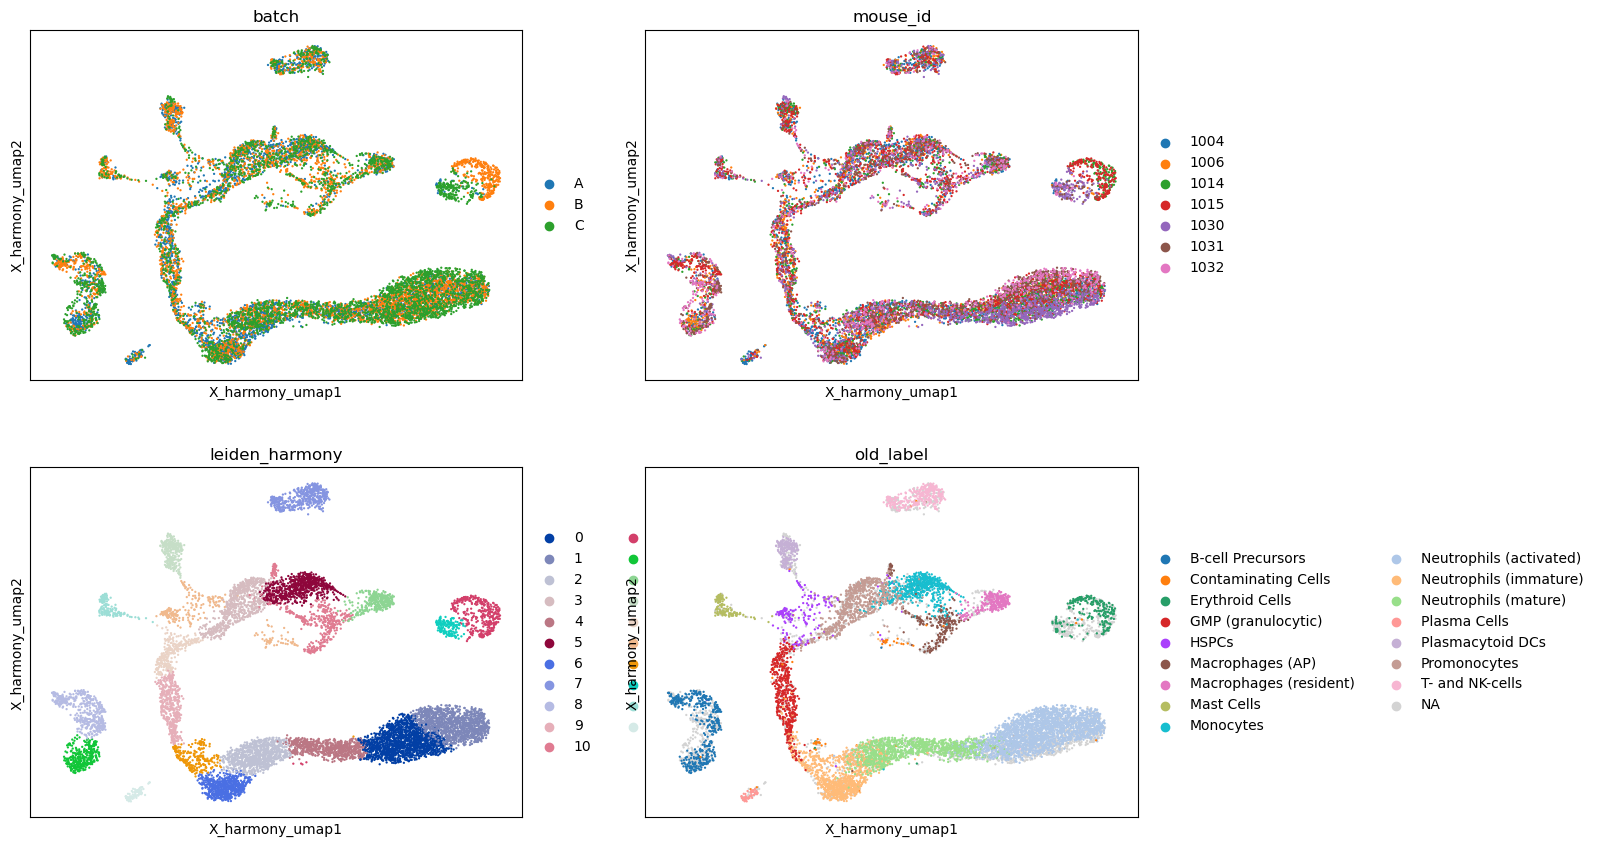

In [47]:
sc.pl.embedding(adata,
                basis = "X_harmony_umap",
                color = ["batch", "mouse_id", "leiden_harmony", "old_label"],
                ncols=2,
                save="overview.png")

V. save results

In [48]:
harmony_df = pd.DataFrame(adata.obsm['X_pca'], 
                       index=adata.obs.index)
harmony_df.to_csv('X_pca_harmony.csv', 
               index=True)

In [49]:
harmony_umap_df = pd.DataFrame(adata.obsm['X_harmony_umap'], 
                               index=adata.obs.index)
harmony_umap_df.to_csv('X_harmony_umap.csv', 
                       index=True)

In [50]:
unintegrated_umap_df = pd.DataFrame(adata.obsm['X_umap_unintegrated'], 
                                    index=adata.obs.index)
unintegrated_umap_df.to_csv('X_umap_unintegrated.csv', 
                            index=True)

In [51]:
meta_df = adata.obs
meta_df.to_csv("ctrl_merged_harmony_meta.csv",
               index=True)